In [1]:
# import the required libraries
import numpy as np
import scipy.stats
import functools
import pandas as pd
import argparse
import scipy as sc
import numpy.matlib as npm
import sys
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
"""
Easiest way to make code work was to copy source code into file, easier than figuring out paths
especially on the maths cluster.
"""

class DeepESN():

    '''
    Deep Echo State Network (DeepESN) class:
    this class implement the DeepESN model suitable for
    time-serie prediction and sequence classification.
    Reference paper for DeepESN model:
    C. Gallicchio, A. Micheli, L. Pedrelli, "Deep Reservoir Computing: A
    Critical Experimental Analysis", Neurocomputing, 2017, vol. 268, pp. 87-99

    Reference paper for the design of DeepESN model in multivariate time-series prediction tasks:
    C. Gallicchio, A. Micheli, L. Pedrelli, "Design of deep echo state networks",
    Neural Networks, 2018, vol. 108, pp. 33-47

    ----
    This file is a part of the DeepESN Python Library (DeepESNpy)
    Luca Pedrelli
    luca.pedrelli@di.unipi.it
    lucapedrelli@gmail.com
    Department of Computer Science - University of Pisa (Italy)
    Computational Intelligence & Machine Learning (CIML) Group
    http://www.di.unipi.it/groups/ciml/
    ----
    '''

    def __init__(self, Nu,Nr,Nl, configs, verbose=0):
        # initialize the DeepESN model

        if verbose:
            sys.stdout.write('init DeepESN...')
            sys.stdout.flush()

        rhos = np.array(configs.rhos) # spectral radius (maximum absolute eigenvalue)
        lis = np.array(configs.lis) # leaky rate
        iss = np.array(configs.iss) # input scale
        IPconf = configs.IPconf # configuration for Deep Intrinsic Plasticity
        reservoirConf = configs.reservoirConf # reservoir configurations

        if len(rhos.shape) == 0:
            rhos = npm.repmat(rhos, 1,Nl)[0]

        if len(lis.shape) == 0:
            lis = npm.repmat(lis, 1,Nl)[0]

        if len(iss.shape) == 0:
            iss = npm.repmat(iss, 1,Nl)[0]

        self.W = {} # recurrent weights
        self.Win = {} # recurrent weights
        self.Gain = {} # activation function gain
        self.Bias = {} # activation function bias

        self.Nu = Nu # number of inputs
        self.Nr = Nr # number of units per layer
        self.Nl = Nl # number of layers
        self.rhos = rhos.tolist() # list of spectral radius
        self.lis = lis # list of leaky rate
        self.iss = iss # list of input scale

        self.IPconf = IPconf

        self.readout = configs.readout

        # sparse recurrent weights init
        if reservoirConf.connectivity < 1:
            for layer in range(Nl):
                self.W[layer] = np.zeros((Nr,Nr))
                for row in range(Nr):
                    number_row_elements = round(reservoirConf.connectivity * Nr)
                    row_elements = random.sample(range(Nr), number_row_elements)
                    self.W[layer][row,row_elements] = np.random.uniform(-1,+1, size = (1,number_row_elements))

        # full-connected recurrent weights init
        else:
            for layer in range(Nl):
                self.W[layer] = np.random.uniform(-1,+1, size = (Nr,Nr))

        # layers init
        for layer in range(Nl):

            target_li = lis[layer]
            target_rho = rhos[layer]
            input_scale = iss[layer]

            if layer==0:
                self.Win[layer] = np.random.uniform(-input_scale, input_scale, size=(Nr,Nu+1))
            else:
                self.Win[layer] = np.random.uniform(-input_scale, input_scale, size=(Nr,Nr+1))

            Ws = (1-target_li) * np.eye(self.W[layer].shape[0], self.W[layer].shape[1]) + target_li * self.W[layer]
            eig_value,eig_vector = np.linalg.eig(Ws)
            actual_rho = np.max(np.absolute(eig_value))

            Ws = (Ws *target_rho)/actual_rho
            self.W[layer] = (target_li**-1) * (Ws - (1.-target_li) * np.eye(self.W[layer].shape[0], self.W[layer].shape[1]))

            self.Gain[layer] = np.ones((Nr,1))
            self.Bias[layer] = np.zeros((Nr,1))

        if verbose:
            print('done.')
            sys.stdout.flush()

    def computeLayerState(self, input, layer, initialStatesLayer = None, DeepIP = 0):
        # compute the state of a layer with pre-training if DeepIP == 1

        state = np.zeros((self.Nr, input.shape[1]))

        if initialStatesLayer is None:
            initialStatesLayer = np.zeros(state[:,0:1].shape)

        input = self.Win[layer][:,0:-1].dot(input) + np.expand_dims(self.Win[layer][:,-1],1)

        if DeepIP:
            state_net = np.zeros((self.Nr, input.shape[1]))
            state_net[:,0:1] = input[:,0:1]
            state[:,0:1] = self.lis[layer] * np.tanh(np.multiply(self.Gain[layer], state_net[:,0:1]) + self.Bias[layer])
        else:
            #state[:,0:1] = self.lis[layer] * np.tanh(np.multiply(self.Gain[layer], input[:,0:1]) + self.Bias[layer])
            state[:,0:1] = (1-self.lis[layer]) * initialStatesLayer + self.lis[layer] * np.tanh( np.multiply(self.Gain[layer], self.W[layer].dot(initialStatesLayer) + input[:,0:1]) + self.Bias[layer])

        for t in range(1,state.shape[1]):
            if DeepIP:
                state_net[:,t:t+1] = self.W[layer].dot(state[:,t-1:t]) + input[:,t:t+1]
                state[:,t:t+1] = (1-self.lis[layer]) * state[:,t-1:t] + self.lis[layer] * np.tanh(np.multiply(self.Gain[layer], state_net[:,t:t+1]) + self.Bias[layer])

                eta = self.IPconf.eta
                mu = self.IPconf.mu
                sigma2 = self.IPconf.sigma**2

                # IP learning rule
                deltaBias = -eta*((-mu/sigma2)+ np.multiply(state[:,t:t+1], (2*sigma2+1-(state[:,t:t+1]**2)+mu*state[:,t:t+1])/sigma2))
                deltaGain = eta / npm.repmat(self.Gain[layer],1,state_net[:,t:t+1].shape[1]) + deltaBias * state_net[:,t:t+1]

                # update gain and bias of activation function
                self.Gain[layer] = self.Gain[layer] + deltaGain
                self.Bias[layer] = self.Bias[layer] + deltaBias

            else:
                state[:,t:t+1] = (1-self.lis[layer]) * state[:,t-1:t] + self.lis[layer] * np.tanh( np.multiply(self.Gain[layer], self.W[layer].dot(state[:,t-1:t]) + input[:,t:t+1]) + self.Bias[layer])

        return state

    def computeDeepIntrinsicPlasticity(self, inputs):
        # we incrementally perform the pre-training (deep intrinsic plasticity) over layers

        len_inputs = range(len(inputs))
        states = []

        for i in len_inputs:
            states.append(np.zeros((self.Nr*self.Nl, inputs[i].shape[1])))

        for layer in range(self.Nl):

            for epoch in range(self.IPconf.Nepochs):
                Gain_epoch = self.Gain[layer]
                Bias_epoch = self.Bias[layer]


                if len(inputs) == 1:
                    self.computeLayerState(inputs[0][:,self.IPconf.indexes], layer, DeepIP = 1)
                else:
                    for i in self.IPconf.indexes:
                        self.computeLayerState(inputs[i], layer, DeepIP = 1)


                if (np.linalg.norm(self.Gain[layer]-Gain_epoch,2) < self.IPconf.threshold) and (np.linalg.norm(self.Bias[layer]-Bias_epoch,2)< self.IPconf.threshold):
                    sys.stdout.write(str(epoch+1))
                    sys.stdout.write('.')
                    sys.stdout.flush()
                    break

                if epoch+1 == self.IPconf.Nepochs:
                    sys.stdout.write(str(epoch+1))
                    sys.stdout.write('.')
                    sys.stdout.flush()

            inputs2 = []
            for i in range(len(inputs)):
                inputs2.append(self.computeLayerState(inputs[i], layer))

            for i in range(len(inputs)):
                states[i][(layer)*self.Nr: (layer+1)*self.Nr,:] = inputs2[i]

            inputs = inputs2

        return states

    def computeState(self,inputs, DeepIP = 0, initialStates = None, verbose=0):
        # compute the global state of DeepESN with pre-training if DeepIP == 1

        if self.IPconf.DeepIP and DeepIP:
            if verbose:
                sys.stdout.write('compute state with DeepIP...')
                sys.stdout.flush()
            states = self.computeDeepIntrinsicPlasticity(inputs)
        else:
            if verbose:
                sys.stdout.write('compute state...')
                sys.stdout.flush()
            states = []

            for i_seq in range(len(inputs)):
                states.append(self.computeGlobalState(inputs[i_seq], initialStates))

        if verbose:
            print('done.')
            sys.stdout.flush()

        return states

    def computeGlobalState(self,input, initialStates):
        # compute the global state of DeepESN

        state = np.zeros((self.Nl*self.Nr,input.shape[1]))

        initialStatesLayer = None


        for layer in range(self.Nl):
            if initialStates is not None:
                initialStatesLayer = initialStates[(layer)*self.Nr: (layer+1)*self.Nr,:]
            state[(layer)*self.Nr: (layer+1)*self.Nr,:] = self.computeLayerState(input, layer, initialStatesLayer, 0)
            input = state[(layer)*self.Nr: (layer+1)*self.Nr,:]

        return state

    def trainReadout(self,trainStates,trainTargets,lb, verbose=0):
        # train the readout of DeepESN

        trainStates = np.concatenate(trainStates,1)
        trainTargets = np.concatenate(trainTargets,1)

        # add bias
        X = np.ones((trainStates.shape[0]+1, trainStates.shape[1]))
        X[:-1,:] = trainStates
        trainStates = X

        if verbose:
            sys.stdout.write('train readout...')
            sys.stdout.flush()

        if self.readout.trainMethod == 'SVD': # SVD, accurate method
            U, s, V = np.linalg.svd(trainStates, full_matrices=False);
            s = s/(s**2 + lb)

            self.Wout = trainTargets.dot(np.multiply(V.T, np.expand_dims(s,0)).dot(U.T));

        else:  # NormalEquation, fast method
            B = trainTargets.dot(trainStates.T)
            A = trainStates.dot(trainStates.T)

            self.Wout = np.linalg.solve((A + np.eye(A.shape[0], A.shape[1]) * lb), B.T).T

        if verbose:
            print('done.')
            sys.stdout.flush()

    def computeOutput(self,state):
        # compute a linear combination between the global state and the output weights
        state = np.concatenate(state,1)
        return self.Wout[:,0:-1].dot(state) + np.expand_dims(self.Wout[:,-1],1) # Wout product + add bias

# Define deep esn function for getting correlation
# Modification of Luca Pedrelli's code
def Causal_ESN_deep(X,Y):

    class Struct(object): pass

    def config_data(IP_indexes):

        configs = Struct()

        configs.rhos = 0.1 # set spectral radius 0.1 for all recurrent layers
        configs.lis = [0.1,0.5,0.9] # set li to 0.1,0.5,0.9 for the recurrent layers
        configs.iss = 1 # set insput scale 0.1 for all recurrent layers

        configs.IPconf = Struct()
        configs.IPconf.DeepIP = 0 # activate pre-train
        configs.IPconf.threshold = 0.1 # threshold for gradient descent in pre-train algorithm
        configs.IPconf.eta = 10e-5 # learning rate for IP rule
        configs.IPconf.mu = 0 # mean of target gaussian function
        configs.IPconf.sigma = 0.1 # std of target gaussian function
        configs.IPconf.Nepochs = 10 # maximum number of epochs
        configs.IPconf.indexes = IP_indexes # perform the pre-train on these indexes

        configs.reservoirConf = Struct()
        configs.reservoirConf.connectivity = 1 # connectivity of recurrent matrix

        configs.readout = Struct()
        configs.readout.trainMethod = 'SVD'
        configs.readout.regularizations = 10.0**np.array(range(-4,-1,1))

        return configs

    def select_indexes(data, indexes, transient=0):

        if len(data) == 1:
            return [data[0][:,indexes][:,transient:]]

        return [data[i][:,transient:] for i in indexes]

    def load_data(X, Y):

        X = np.reshape(X,(1,X.shape[0]))
        Y = np.reshape(Y,(1,Y.shape[0]))
 
        dataset = Struct()
        dataset.name = ['DATA']
        dataset.inputs = [X]
        dataset.targets = [Y]

        # input dimension
        Nu = dataset.inputs[0].shape[0]


        # select the model that achieves the maximum accuracy on validation set
        optimization_problem = np.argmin

        # set size of training set
        tr_ind = int(X.shape[1]*0.8)

        TR_indexes = range(tr_ind) 
        VL_indexes = range(tr_ind,X.shape[1])
        TS_indexes = range(Y.shape[1])

        return dataset, Nu, optimization_problem, TR_indexes, VL_indexes, TS_indexes

    dataset, Nu, optimization_problem, TR_indexes, VL_indexes, TS_indexes = load_data(X, Y)

    # load configuration for pianomidi task
    configs = config_data(list(TR_indexes) + list(VL_indexes))

    Nr = 100 # number of recurrent units
    Nl = 3 # number of recurrent layers
    reg = 10.0e-6
    transient = 5

    deepESN = DeepESN(Nu, Nr, Nl, configs, verbose = 0)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)

    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)
    deepESN.trainReadout(train_states, train_targets, reg)

    train_outputs = deepESN.computeOutput(train_states)

    test_outputs = deepESN.computeOutput(test_states)

    corr = scipy.stats.spearmanr(test_outputs, test_targets[0], axis = 1)

    return corr

In [3]:
# define function to run surrogate time series through deep esn
def compute_confidence(X_data, Y_data, verbose = False):

    n, T = X_data.shape

    lags = np.arange(0,21)
    xmapy = np.zeros((n,21))
    ymapx = np.zeros((n,21))

    for j in range(n):
        if verbose:
            if (j%20 == 0):
                print("Current Iteration {}".format(j))
        for i in range(21):

            if i < 11:
                L1 = 10 - i
                R1 = T
                L2 = 0
                R2 = T - 10 + i

            else:
                L1 = 0
                R1 = T - i + 10
                L2 = i - 10
                R2 = T

            X = X_data[j,L1:R1]
            Y = Y_data[j,L2:R2]
            xmapy[j,i] = Causal_ESN_deep(X,Y)[0]

            Y = Y_data[j,L1:R1]
            X = X_data[j,L2:R2]
            ymapx[j,i] = Causal_ESN_deep(Y,X)[0]

    return xmapy, ymapx

In [4]:
# define function to run actual time series through deep esn
def compute_lags(X_data, Y_data, n, verbose = False):

    T = X_data.shape[0]

    lags = np.arange(0,21)
    xmapy = np.zeros((n,21))
    ymapx = np.zeros((n,21))

    for j in range(n):
        if verbose:
            if (j%20 == 0):
                print("Current Iteration {}".format(j))
        for i in range(21):

            if i < 11:
                L1 = 10 - i
                R1 = T
                L2 = 0
                R2 = T - 10 + i

            else:
                L1 = 0
                R1 = T - i + 10
                L2 = i - 10
                R2 = T

            X = X_data[L1:R1]
            Y = Y_data[L2:R2]
            xmapy[j,i] = Causal_ESN_deep(X,Y)[0]

            Y = Y_data[L1:R1]
            X = X_data[L2:R2]
            ymapx[j,i] = Causal_ESN_deep(Y,X)[0]

    return xmapy, ymapx

In [6]:
def compute_ci(data):

    n = data.shape[1]
    se = scipy.stats.sem(data, axis = 0)
    h = se * scipy.stats.t.ppf(1.95 / 2., n-1)
    return h

In [7]:
def lag_fig(xmapy_surr, ymapx_surr, xmapy, ymapx, x_name, y_name):
    x = np.arange(-10,11)

    mean_xmapy = xmapy.mean(axis = 0)
    mean_ymapx = ymapx.mean(axis = 0)

    ci_xmapy = compute_ci(xmapy)
    ci_ymapx = compute_ci(ymapx)

    fig = plt.figure(figsize = (8,6))
    
#     name_x = x_name[:3]
#     name_y = y_name[:3]

    plt.plot(x, mean_xmapy, 'C0-', label= r'Y $\rightarrow$ X')
    plt.plot(x, xmapy_surr.mean(axis = 0), 'C0--', label = r'Y $\rightarrow$ X surrogate')
    plt.fill_between(x, mean_xmapy - ci_xmapy, mean_xmapy + ci_xmapy, color='C0', alpha=0.2)

    plt.plot(x, mean_ymapx, 'C1-', label= r'X $\rightarrow$ Y')
    plt.plot(x, ymapx_surr.mean(axis = 0), 'C1--', label = r'X $\rightarrow$ Y surrogate')
    plt.fill_between(x, mean_ymapx - ci_ymapx, mean_ymapx + ci_ymapx, color='C1', alpha=0.2)

    plt.xticks(x)
    plt.grid(linestyle = '--', alpha = 0.5)

    plt.ylabel(r'$\rho$', rotation = 0)
    plt.xlabel(r'$\tau$')
    #plt.title('Correlation vs Lag')
    plt.legend(loc = 1)
    #plt.savefig('test.png', dpi=300)

#     return fig

In [8]:
"""
Cell that simulates the above described uni-directionally forced logistic map.
"""
# initialise x and y arrays
x = np.zeros(10000)
y = np.zeros(10000)
# set inital conditions
x[0] = 0.2
y[0] = 0.4
# run through first couple of instances to get process going
for i in range(1,13):
    x[i] = x[i-1] * (3.78 - 3.78*x[i-1])
    y[i] = y[i-1] * (3.1 - 3.1*y[i-1])
# run for rest of length with the coupling
for i in range(13, 10000):
    x[i] = x[i-1] * (3.78 - 3.78*x[i-1])
    y[i] = y[i-1] * (3.1 - 3.1*y[i-1] - 0.08*x[i-5])

In [9]:
"""
Get artificial time series of length 250, 500 and 1000 by slicing from above
generated data.
"""
x_250 = x[9750:]
y_250 = y[9750:]

# standardise time series
from sklearn import preprocessing

x_250 = preprocessing.scale(x_250)
y_250 = preprocessing.scale(y_250)

In [10]:
# x_axis = np.arange(-10,11)

# # set up grid for plots
# fig, axs = plt.subplots(figsize = (24,8), nrows = 1, ncols = 3, sharex = False, sharey = False)

# # plot figures
# mean_y1mapy2 = xmapy40.mean(axis = 0)
# mean_y2mapy1 = ymapx40.mean(axis = 0)
# ci_y1mapy2 = compute_ci(xmapy40)
# ci_y2mapy1 = compute_ci(ymapx40)

# axs[0].plot(x_axis, mean_y1mapy2, 'C0-', label= r'y $\rightarrow$ x')
# axs[0].plot(x_axis, xmapy_surr40.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
# axs[0].fill_between(x_axis, mean_y1mapy2 - ci_y1mapy2, mean_y1mapy2 + ci_y1mapy2, color='C0', alpha=0.2)

# axs[0].plot(x_axis, mean_y2mapy1, 'C1-', label= r'x $\rightarrow$ y')
# axs[0].plot(x_axis, ymapx_surr40.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
# axs[0].fill_between(x_axis, mean_y2mapy1 - ci_y2mapy1, mean_y2mapy1 + ci_y2mapy1, color='C1', alpha=0.2)

# axs[0].set_xticks(x_axis)
# axs[0].grid(linestyle = '--', alpha = 0.5)


# mean_y1mapy3 = xmapy80.mean(axis = 0)
# mean_y3mapy1 = ymapx80.mean(axis = 0)
# ci_y1mapy3 = compute_ci(xmapy80)
# ci_y3mapy1 = compute_ci(ymapx80)

# axs[1].plot(x_axis, mean_y1mapy3, 'C0-', label= r'y $\rightarrow$ x')
# axs[1].plot(x_axis, xmapy_surr80.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
# axs[1].fill_between(x_axis, mean_y1mapy3 - ci_y1mapy3, mean_y1mapy3 + ci_y1mapy3, color='C0', alpha=0.2)

# axs[1].plot(x_axis, mean_y3mapy1, 'C1-', label= r'x $\rightarrow$ y')
# axs[1].plot(x_axis, ymapx_surr80.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
# axs[1].fill_between(x_axis, mean_y3mapy1 - ci_y3mapy1, mean_y3mapy1 + ci_y3mapy1, color='C1', alpha=0.2)

# axs[1].set_xticks(x_axis)
# axs[1].grid(linestyle = '--', alpha = 0.5)


# mean_y1mapy4 = xmapy2.mean(axis = 0)
# mean_y4mapy1 = ymapx2.mean(axis = 0)
# ci_y1mapy4 = compute_ci(xmapy2)
# ci_y4mapy1 = compute_ci(ymapx2)

# axs[2].plot(x_axis, mean_y1mapy4, 'C0-', label= r'y $\rightarrow$ x')
# axs[2].plot(x_axis, xmapy_surr2.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
# axs[2].fill_between(x_axis, mean_y1mapy4 - ci_y1mapy4, mean_y1mapy4 + ci_y1mapy4, color='C0', alpha=0.2)

# axs[2].plot(x_axis, mean_y4mapy1, 'C1-', label= r'x $\rightarrow$ y')
# axs[2].plot(x_axis, ymapx_surr2.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
# axs[2].fill_between(x_axis, mean_y4mapy1 - ci_y4mapy1, mean_y4mapy1 + ci_y4mapy1, color='C1', alpha=0.2)

# axs[2].set_xticks(x_axis)
# axs[2].grid(linestyle = '--', alpha = 0.5)


# axs[0].legend(loc = 1)
# axs[1].legend(loc = 1)
# axs[2].legend(loc = 1)

# axs[0].title.set_text('20% seasonality')
# axs[1].title.set_text('40% seasonality')
# axs[2].title.set_text('80% seasonality')

# axs[0].set_xlabel(r"$\tau$")
# axs[1].set_xlabel(r"$\tau$")
# axs[2].set_xlabel(r"$\tau$")

# axs[0].set_ylabel(r"$\rho$", rotation = 0)


# # optionally save figures after plotting
# #plt.savefig('weakuni_seas.png', dpi=300, bbox_inches='tight')
# plt.show()

In [11]:
from itertools import combinations
import pyEDM
import seaborn as sns
from joblib import Parallel, delayed
from numpy.random import default_rng
from scipy.spatial.distance import squareform, pdist



def recurrence_matrix(x_e, quantile_per=12.5):
    """
    Generates binary recurrence matrix, where the closest ``quantile_per``% of pairwise distances are assigned a 1,
    and all other pairs assigned a 0.
    :param x_e: embedded dataframe of the required form such as that generated through ``pyEDM.Embed()``
    :param quantile_per: percentile of distances to set equal to 1
    :return: dataframe of recurrence matrix
    """
    dist_mat = squareform(pdist(x_e.values, metric="chebyshev"))
    binary_dist_mtx = (dist_mat <= np.percentile(dist_mat, quantile_per)).astype(int)
    # print("1s: ", np.count_nonzero(binary_dist_mtx) / (len(binary_dist_mtx) ** 2))
    return binary_dist_mtx

def twins_list(len_df, Ng, r_mtx, obs_per_year=12):
    """
    Creates an array of all twin points. Twin points are defined as those which are sufficiently close together in
    state space (same column in the recurrence matrix) and have the same seasonality (measurements from the same month)
    :param len_df: length of original dataframe (i.e. length of time series)
    :param Ng: length of embedded dataframe
    :param r_mtx: recurrence matrix dataframe
    :param obs_per_year: seasonality of the data
    :return: array of twins, formatted in two different ways. A_arr is the useful format for what follows
    """
    Eminus1 = len_df - Ng
    Alist = [[i] for i in range(len_df)]
    for i, j in combinations(range(Ng), 2):  # does not include repeats
        if np.array_equal(r_mtx[:, i], r_mtx[:, j]) and (j - i) % obs_per_year == 0:
            Alist[i + Eminus1].append(j + Eminus1)
            Alist[j + Eminus1].append(i + Eminus1)
    Q = np.array([len(twins) for twins in Alist])
    A_arr = (
        np.zeros((len_df, np.max(Q)), dtype=int) - 1000
    )  # -1000 here after trying it
    for i in range(len_df):
        A_arr[i, : Q[i]] = Alist[i]
    return A_arr, Q



def network_surrogates(len_df, twins_arr, Q, Ng, M=100, obs_per_year=12):
    """
    Generate all surrogates using a network method described in report. First generate points in phase space,
    and then append on initial time series
    :param len_df: length of original dataframe (i.e. length of time series)
    :param twins_arr: array of the twin points of every point (e.g. ouput of twins list
    :param Q: array of degrees of each node
    :param Ng: length of embedded dataframe/ number of nodes
    :param M: number of walkers starting on each node
    :param obs_per_year: sampling observations per year of data
    :return: arrays for which each column is a surrogate
    """
    nodes = np.arange(Ng - 2)
    Eminus1 = len_df - Ng
    start_nodes = nodes[nodes % obs_per_year == 0]
    start_nodes = start_nodes[start_nodes >= obs_per_year]
    num_nodes = len(start_nodes)
    X = np.zeros((Ng, M, num_nodes), dtype=int)
    X[0, :, :] = np.tile(start_nodes, (M, 1))

    rng = default_rng()  # generate random numbers (using numpy generator method)
    rand1 = rng.random((Ng, M, num_nodes))

    for i in range(1, Ng):
        X[i, :, :] = X[i - 1, :, :]
        QX = Q[X[i, :, :]]  # degrees of nodes where each walker is currently
        Ri = (
            rand1[i, :, :] * QX
        )  # Generate array of random numbers, each less than QX[i,j]
        Ri = Ri.astype(int)  # integer conversion
        mask = X[i, :, :] < (Ng - 1)  # relax this condition to let points jump off
        X[i, :, :][mask] = twins_arr[X[i, :, :], Ri][mask]  # update walker locations
        X[i, :, :][X[i, :, :] < (Ng - 1)] += 1
    surrogates = X[:, X[-1, :, :] < (Ng - 1)]
    # back propagate initial times to get to full length of time series
    initial_times = np.add(
        np.tile(surrogates[0, :] - Eminus1, (Eminus1, 1)),
        np.mgrid[:Eminus1, : len(surrogates[0, :])][0],
    )
    return np.concatenate((initial_times, surrogates))  # each column is a surrogate!!


def run_surrogates(df, mae_dict, sp, n_surrogates=5, obs_per_year=12, thresholds=-1):
    """
    Generates all the surrogates using the rEDM method. Note the ability to insert a list of
    thresholds to try. Default is the rEDM implementation list of thresholds to try.
    :param df: input dataframe
    :param mae_dict: dictionary of lists; generate with :meth:`src.processing.embedding_dimension.mae_dictionary`
    :param sp: species for which to generate surrogates
    :param n_surrogates: number of surrogates to generate
    :param obs_per_year: period of seasonality of data
    :param thresholds: list of thresholds to try. Numbers between 5 and 20 recommended.
    :return: embedded dataframe, surrogates, optimal embedding dimension
    """
    surrogate_slice = None
    optE = 0
    len_df = len(df)
    for count in range(25):
        optE = mae_dict[sp][count][0]
        x_e = pyEDM.Embed(dataFrame=df, E=optE, columns=sp)
        Ng = len(x_e)
        if thresholds == -1:
            thresholds = [
                12.5,
                12,
                11,
                10,
                9,
                8,
                7,
                6,
                5,
                15,
                16,
                17,
                18,
                19,
                20,
                4,
            ]
        twins_arr = None
        Q = None
        for thres in thresholds:
            r_mtx = recurrence_matrix(x_e, thres)
            twins_arr, Q = twins_list(
                len_df, Ng=Ng, r_mtx=r_mtx, obs_per_year=obs_per_year
            )
            # if there are at least 10 twins
            if np.sum(Q) - Ng > 10:
                break
        surrogate_slice = network_surrogates(
            len_df, twins_arr, Q, Ng, M=100 * n_surrogates, obs_per_year=obs_per_year
        )
        if len(surrogate_slice[0, :]) >= n_surrogates:
            print("E = {}".format(optE))
            print("Threshold = {}".format(thres))
            break
    rng = default_rng()
    return (
        x_e,
        rng.choice(a=surrogate_slice, size=n_surrogates, replace=False, axis=1),
        optE,
    )


def generate_all_surrogates(df, mae_dict, n_surrogates=5, obs_per_year=12):
    """
    Generates surrogates for all species of a given dataframe, using the :meth:`src.PLTS.networkccm3.run_surrogates`
    method.
    :param df: input dataframe
    :param mae_dict: dictionary of lists; generate with :meth:`src.processing.embedding_dimension.mae_dictionary`
    :param n_surrogates: number of surrogates to use with phase-lock twin surrogate method
    :param obs_per_year: periodicity of time series data (12 for Guadalquivir data, 24 for Maizuru data)
    :return: length of embedded dataframe, array of surrogate time series, array of optimal embedding dimensions
    """
    species_list = list(df.columns[1:])
    len_df = len(df)
    surr_array = np.zeros((len(species_list), len_df, n_surrogates))
    Es = np.zeros(len(species_list))
    for i, sp in enumerate(species_list):
        x_e, surr_array[i], Es[i] = run_surrogates(
            df, mae_dict, sp, n_surrogates=n_surrogates, obs_per_year=obs_per_year
        )
    return x_e, surr_array, Es.astype(int)



def mae_dictionary(df, max_dim=24):
    """
    Creates dictionary with species as keys and each corresponding index a list of embedding dimensions from 1 to
    max_dim in order of optimality according to mean absolute error. See section 3.2 of report.
    :param df: input dataframe of usual form (e.g. that given by :meth:`src.abundance_tools.initialise_dataset`)
    :param max_dim: maximum embedding dimension to include in dictionary. Default is 24, copying Ushio paper
    :return: dictionary of optimal embedding dimension information
    """
    mae_dict = {}
    for _, sp in enumerate(df.columns[1:]):
        MAEs = [[] for _ in range(2, max_dim + 1)]
        for E in range(2, max_dim + 1):
            library_string = "1 {}".format(len(df) - E)
            preds = pyEDM.Simplex(
                dataFrame=df,
                columns=sp,
                target=sp,
                E=E,
                Tp=1,
                lib=library_string,
                pred=library_string,
                exclusionRadius=1,
            )
            MAEs[E - 2] = [
                E,
                np.nanmean(
                    np.abs((preds["Predictions"] - preds["Observations"]).values)
                ),
            ]
        mae_dict[sp] = MAEs
    for sp in mae_dict:
        mae_dict[sp].sort(key=takeSecond)
    return mae_dict

def takeSecond(elem):
    """
    Returns second element of a list. Auxiliary function for :meth:`src.processing.embedding_dimension.mae_dictionary`
    :param elem: list
    :return: second element
    """
    return elem[1]


def twin_surrogate_esn(X, Y, Nsurr, period):
    df = pd.DataFrame()
    df['X'] = X
    df['Y'] = Y
    df.insert(loc=0, column="Time", value=range(len(df)))
    
    df_mae_dict = mae_dictionary(df, max_dim=24)
    _, surr_array, _ = generate_all_surrogates(df, df_mae_dict, n_surrogates = Nsurr, obs_per_year = period)
    
    return surr_array[0,:,:].T, surr_array[1,:,:].T

def DeepESN_seasonal(X, Y, seasonality_strength = 0, n_data = 50, period = 10, verbose = False):
    
    # Get length of time series
    N = X.shape[0]
    
    # add seasonality to X and Y
    s = np.sin(np.linspace(0, 2 * np.pi, 10 + 1))
    seasonality = np.tile(s[:-1], 25)
    Xseas = X + seasonality_strength*seasonality
    Yseas = Y + seasonality_strength*seasonality
    
    
    # compute surrogates
    Xsurr, Ysurr = twin_surrogate_esn(Xseas, Yseas, Nsurr = n_data, period = period)
    
    
    # run the deepESN of the surrogates
    xmapy_surr, ymapx_surr = compute_confidence(Xsurr, Ysurr, verbose)

    # run deepESN for actual data
    xmapy, ymapx = compute_lags(Xseas, Yseas, n_data, verbose)

    return xmapy_surr, ymapx_surr, xmapy, ymapx

xmapy_surr10, ymapx_surr10, xmapy10, ymapx10 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.1, period = 10)

In [12]:
xmapy_surr20, ymapx_surr20, xmapy20, ymapx20 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.2, period = 10)

E = 3
Threshold = 12.5
E = 4
Threshold = 11


xmapy_surr30, ymapx_surr30, xmapy30, ymapx30 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.3, period = 10)

xmapy_surr40, ymapx_surr40, xmapy40, ymapx40 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.4, period = 10)

In [13]:
xmapy_surr60, ymapx_surr60, xmapy60, ymapx60 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.6, period = 10)

E = 5
Threshold = 12.5
E = 4
Threshold = 9


xmapy_surr80, ymapx_surr80, xmapy80, ymapx80 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 0.8, period = 10)

In [14]:
xmapy_surr2, ymapx_surr2, xmapy2, ymapx2 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 2, period = 10)

E = 3
Threshold = 12.5
E = 4
Threshold = 12.5


In [15]:
xmapy_surr1, ymapx_surr1, xmapy1, ymapx1 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 1, period = 10)

E = 5
Threshold = 12.5
E = 5
Threshold = 12


In [16]:
xmapy_surr15, ymapx_surr15, xmapy15, ymapx15 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 1.5, period = 10)

E = 3
Threshold = 12.5
E = 4
Threshold = 12


xmapy_surr175, ymapx_surr175, xmapy175, ymapx175 = DeepESN_seasonal(x_250, y_250, seasonality_strength = 1.75, period = 10)

lag_fig(xmapy_surr10, ymapx_surr10, xmapy10, ymapx10, 'x', 'y')

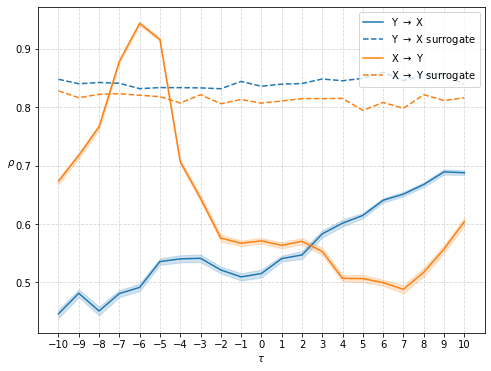

In [17]:
lag_fig(xmapy_surr20, ymapx_surr20, xmapy20, ymapx20, 'x', 'y')

lag_fig(xmapy_surr30, ymapx_surr30, xmapy30, ymapx30, 'x', 'y')

lag_fig(xmapy_surr40, ymapx_surr40, xmapy40, ymapx40, 'x', 'y')

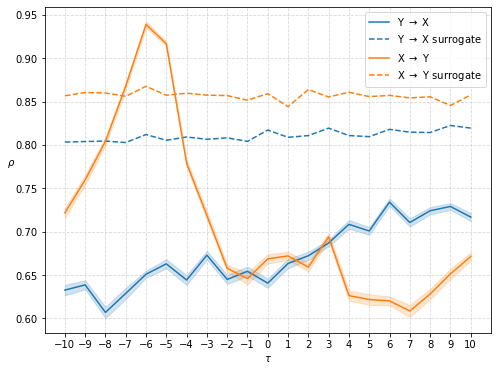

In [18]:
lag_fig(xmapy_surr60, ymapx_surr60, xmapy60, ymapx60, 'x', 'y')

lag_fig(xmapy_surr80, ymapx_surr80, xmapy80, ymapx80, 'x', 'y')

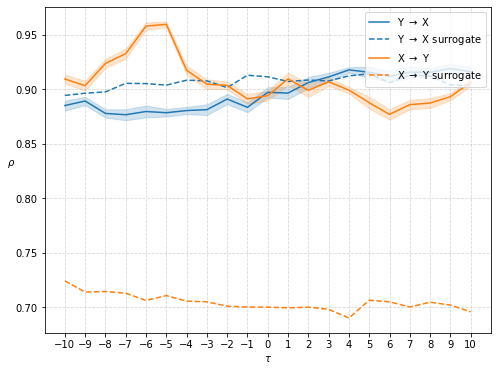

In [19]:
lag_fig(xmapy_surr2, ymapx_surr2, xmapy2, ymapx2, 'x', 'y')

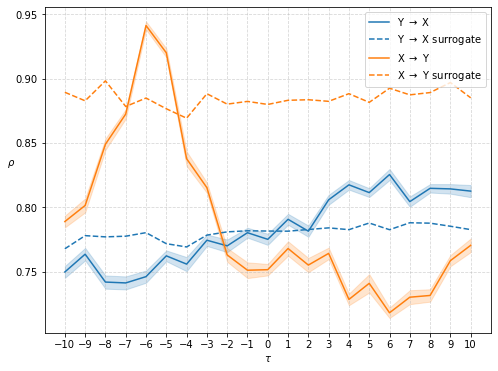

In [20]:
lag_fig(xmapy_surr1, ymapx_surr1, xmapy1, ymapx1, 'x', 'y')

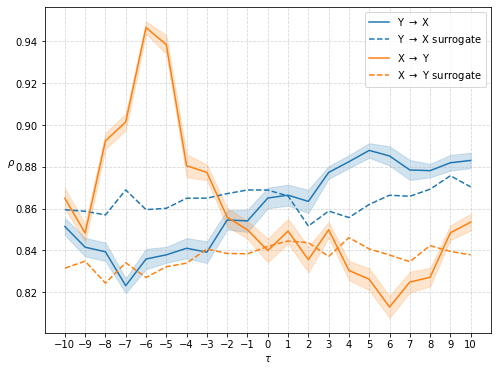

In [21]:
lag_fig(xmapy_surr15, ymapx_surr15, xmapy15, ymapx15, 'x', 'y')

lag_fig(xmapy_surr175, ymapx_surr175, xmapy175, ymapx175, 'x', 'y')

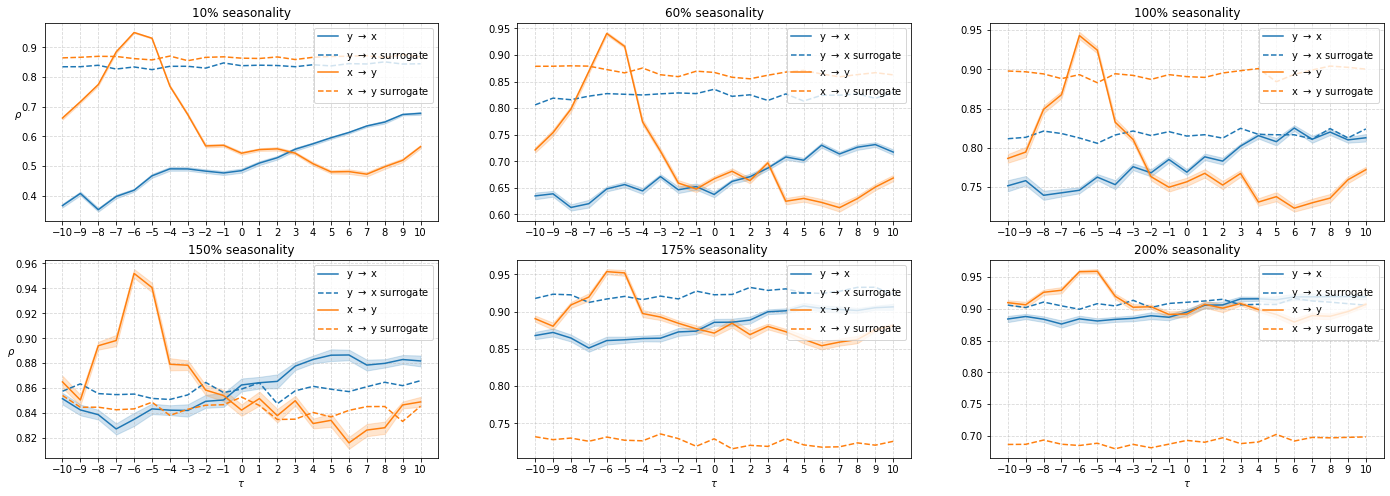

In [40]:
x_axis = np.arange(-10,11)

# set up grid for plots
fig, axs = plt.subplots(figsize = (24,8), nrows = 2, ncols = 3, sharex = False, sharey = False)

# plot figures
mean_y1mapy2 = xmapy10.mean(axis = 0)
mean_y2mapy1 = ymapx10.mean(axis = 0)
ci_y1mapy2 = compute_ci(xmapy10)
ci_y2mapy1 = compute_ci(ymapx10)

axs[0,0].plot(x_axis, mean_y1mapy2, 'C0-', label= r'y $\rightarrow$ x')
axs[0,0].plot(x_axis, xmapy_surr10.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[0,0].fill_between(x_axis, mean_y1mapy2 - ci_y1mapy2, mean_y1mapy2 + ci_y1mapy2, color='C0', alpha=0.2)

axs[0,0].plot(x_axis, mean_y2mapy1, 'C1-', label= r'x $\rightarrow$ y')
axs[0,0].plot(x_axis, ymapx_surr10.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[0,0].fill_between(x_axis, mean_y2mapy1 - ci_y2mapy1, mean_y2mapy1 + ci_y2mapy1, color='C1', alpha=0.2)

axs[0,0].set_xticks(x_axis)
axs[0,0].grid(linestyle = '--', alpha = 0.5)


mean_y1mapy3 = xmapy60.mean(axis = 0)
mean_y3mapy1 = ymapx60.mean(axis = 0)
ci_y1mapy3 = compute_ci(xmapy60)
ci_y3mapy1 = compute_ci(ymapx60)

axs[0,1].plot(x_axis, mean_y1mapy3, 'C0-', label= r'y $\rightarrow$ x')
axs[0,1].plot(x_axis, xmapy_surr60.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[0,1].fill_between(x_axis, mean_y1mapy3 - ci_y1mapy3, mean_y1mapy3 + ci_y1mapy3, color='C0', alpha=0.2)

axs[0,1].plot(x_axis, mean_y3mapy1, 'C1-', label= r'x $\rightarrow$ y')
axs[0,1].plot(x_axis, ymapx_surr60.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[0,1].fill_between(x_axis, mean_y3mapy1 - ci_y3mapy1, mean_y3mapy1 + ci_y3mapy1, color='C1', alpha=0.2)

axs[0,1].set_xticks(x_axis)
axs[0,1].grid(linestyle = '--', alpha = 0.5)


mean_y1mapy4 = xmapy1.mean(axis = 0)
mean_y4mapy1 = ymapx1.mean(axis = 0)
ci_y1mapy4 = compute_ci(xmapy1)
ci_y4mapy1 = compute_ci(ymapx1)

axs[0,2].plot(x_axis, mean_y1mapy4, 'C0-', label= r'y $\rightarrow$ x')
axs[0,2].plot(x_axis, xmapy_surr1.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[0,2].fill_between(x_axis, mean_y1mapy4 - ci_y1mapy4, mean_y1mapy4 + ci_y1mapy4, color='C0', alpha=0.2)

axs[0,2].plot(x_axis, mean_y4mapy1, 'C1-', label= r'x $\rightarrow$ y')
axs[0,2].plot(x_axis, ymapx_surr1.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[0,2].fill_between(x_axis, mean_y4mapy1 - ci_y4mapy1, mean_y4mapy1 + ci_y4mapy1, color='C1', alpha=0.2)

axs[0,2].set_xticks(x_axis)
axs[0,2].grid(linestyle = '--', alpha = 0.5)


# axs[0,0].title.set_text('250 data points')
# axs[0,1].title.set_text('500 data points')
# axs[0,2].title.set_text('1000 data points')


axs[0,0].legend(loc = 1)
axs[0,1].legend(loc = 1)
axs[0,2].legend(loc = 1)

axs[0,0].title.set_text('10% seasonality')
axs[0,1].title.set_text('60% seasonality')
axs[0,2].title.set_text('100% seasonality')

# axs[0,0].set_xlabel(r"$\tau$")
# axs[0,1].set_xlabel(r"$\tau$")
# axs[0,2].set_xlabel(r"$\tau$")

axs[0,0].set_ylabel(r"$\rho$", rotation = 0)



mean_y2mapy3 = xmapy15.mean(axis = 0)
mean_y3mapy2 = ymapx15.mean(axis = 0)
ci_y2mapy3 = compute_ci(xmapy15)
ci_y3mapy2 = compute_ci(ymapx15)

axs[1,0].plot(x_axis, mean_y2mapy3, 'C0-', label= r'y $\rightarrow$ x')
axs[1,0].plot(x_axis, xmapy_surr15.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[1,0].fill_between(x_axis, mean_y2mapy3 - ci_y2mapy3, mean_y2mapy3 + ci_y2mapy3, color='C0', alpha=0.2)

axs[1,0].plot(x_axis, mean_y3mapy2, 'C1-', label= r'x $\rightarrow$ y')
axs[1,0].plot(x_axis, ymapx_surr15.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[1,0].fill_between(x_axis, mean_y3mapy2 - ci_y3mapy2, mean_y3mapy2 + ci_y3mapy2, color='C1', alpha=0.2)

axs[1,0].set_xticks(x_axis)
axs[1,0].grid(linestyle = '--', alpha = 0.5)


mean_y2mapy4 = xmapy175.mean(axis = 0)
mean_y4mapy2 = ymapx175.mean(axis = 0)
ci_y2mapy4 = compute_ci(xmapy175)
ci_y4mapy2 = compute_ci(ymapx175)

axs[1,1].plot(x_axis, mean_y2mapy4, 'C0-', label= r'y $\rightarrow$ x')
axs[1,1].plot(x_axis, xmapy_surr175.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[1,1].fill_between(x_axis, mean_y2mapy4 - ci_y2mapy4, mean_y2mapy4 + ci_y2mapy4, color='C0', alpha=0.2)

axs[1,1].plot(x_axis, mean_y4mapy2, 'C1-', label= r'x $\rightarrow$ y')
axs[1,1].plot(x_axis, ymapx_surr175.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[1,1].fill_between(x_axis, mean_y4mapy2 - ci_y4mapy2, mean_y4mapy2 + ci_y4mapy2, color='C1', alpha=0.2)

axs[1,1].set_xticks(x_axis)
axs[1,1].grid(linestyle = '--', alpha = 0.5)


mean_y3mapy4 = xmapy2.mean(axis = 0)
mean_y4mapy3 = ymapx2.mean(axis = 0)
ci_y3mapy4 = compute_ci(xmapy2)
ci_y4mapy3 = compute_ci(ymapx2)

axs[1,2].plot(x_axis, mean_y3mapy4, 'C0-', label= r'y $\rightarrow$ x')
axs[1,2].plot(x_axis, xmapy_surr2.mean(axis = 0), 'C0--', label = r'y $\rightarrow$ x surrogate')
axs[1,2].fill_between(x_axis, mean_y3mapy4 - ci_y3mapy4, mean_y3mapy4 + ci_y3mapy4, color='C0', alpha=0.2)

axs[1,2].plot(x_axis, mean_y4mapy3, 'C1-', label= r'x $\rightarrow$ y')
axs[1,2].plot(x_axis, ymapx_surr2.mean(axis = 0), 'C1--', label = r'x $\rightarrow$ y surrogate')
axs[1,2].fill_between(x_axis, mean_y4mapy3 - ci_y4mapy3, mean_y4mapy3 + ci_y4mapy3, color='C1', alpha=0.2)

axs[1,2].set_xticks(x_axis)
axs[1,2].grid(linestyle = '--', alpha = 0.5)


# axs[0,0].title.set_text('250 data points')
# axs[0,1].title.set_text('500 data points')
# axs[0,2].title.set_text('1000 data points')


axs[1,0].legend(loc = 1)
axs[1,1].legend(loc = 1)
axs[1,2].legend(loc = 1)

axs[1,0].title.set_text('150% seasonality')
axs[1,1].title.set_text('175% seasonality')
axs[1,2].title.set_text('200% seasonality')

axs[1,0].set_xlabel(r"$\tau$")
axs[1,1].set_xlabel(r"$\tau$")
axs[1,2].set_xlabel(r"$\tau$")

axs[1,0].set_ylabel(r"$\rho$", rotation = 0)

# optionally save figures after plotting
#plt.savefig('weakuni_seas.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
correlations20 = np.dstack((xmapy_surr20,ymapx_surr20,xmapy20,ymapx20))
correlations60 = np.dstack((xmapy_surr60,ymapx_surr60,xmapy60,ymapx60))
correlations1 = np.dstack((xmapy_surr1,ymapx_surr1,xmapy1,ymapx1))
correlations15 = np.dstack((xmapy_surr15,ymapx_surr15,xmapy15,ymapx15))
correlations2 = np.dstack((xmapy_surr2,ymapx_surr2,xmapy2,ymapx2))

In [23]:
np.save('WeakUniSeas20', correlations20)
np.save('WeakUniSeas60', correlations60)
np.save('WeakUniSeas1', correlations1)
np.save('WeakUniSeas15', correlations15)
np.save('WeakUniSeas2', correlations2)